In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')


import neuralop as op
from neuralop.models import FNO, LocalFNO, UNO, TFNO
import jaxwt as jwt
import pcax
from jax.scipy.stats import norm, laplace

In [2]:
def fourier_sample(rng, n, p, n_freq = 20):
    x = jnp.linspace(0, 1, p)
    f = 0
    for i in range(n_freq):
        rng, key1, key2 = random.split(rng, 3)
        
        an = 1/(n_freq+1) * random.normal(key1, (n, 1))
        bn = 1/(n_freq+1) * random.normal(key2, (n, 1))

        f += an * jnp.cos(2*math.pi * i * x)[None,]
        f += bn * jnp.sin(2*math.pi * i * x)[None,]

    f += random.normal(rng, (n, 1))
    return f

In [43]:
n, p = 300, 1000
beta = random.normal(random.PRNGKey(0), (3,))
bias = 1
n_freq = 20

## train
rng = random.PRNGKey(0)
key1, key2 = random.split(rng)

xtrain = fourier_sample(key1, n, p, n_freq)
sigma = jnp.mean((xtrain)**2, axis = 1)[:,None]
epsilon = sigma * fourier_sample(key2, n, p, n_freq)
ytrain = bias + conv(xtrain, beta) + epsilon

xtrain = xtrain[:,None]
ytrain = ytrain[:,None]

## val
rng = random.PRNGKey(1)
key1, key2 = random.split(rng)

xval = fourier_sample(key1, n, p, n_freq)
sigma = jnp.mean((xval)**2, axis = 1)[:,None]
epsilon = sigma * fourier_sample(key2, n, p, n_freq)
yval = bias + conv(xval, beta) + epsilon

xval = xval[:,None]
yval = yval[:,None]

In [44]:
train_data = TensorDataset(jax2torch(xtrain), jax2torch(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [45]:
loss_fn = nn.MSELoss()

fno = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
optim_fno = torch.optim.Adam(fno.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()
        
with torch.no_grad():
    yval_fno = jnp.array(np.array(fno(jax2torch(xval)).squeeze()))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
# ### test
# rng = random.PRNGKey(2)
# key1, key2 = random.split(rng)

# xtest = fourier_sample(key1, n, p)
# sigma = jnp.mean((xtest)**2, axis = 1)[:,None]
# epsilon = sigma * fourier_sample(key2, n, p)
# ytest = bias + conv(xtest, beta) + epsilon

# xtest = xtest[:,None]
# ytest = ytest[:,None]
# with torch.no_grad():
#     ytest_fno = jnp.array(np.array(fno(jax2torch(xtest)).squeeze()))

In [47]:
# ### residuals
# rval_fno = yval.squeeze() - yval_fno
# rtest_fno = ytest.squeeze() - ytest_fno

# ## split again
# keyR, keyW, keyF = random.split(key3, 3)

In [48]:
# i = 40

# phi = slice_phi(sub_rng, p, 20)
# rval_phi = rval_fno @ phi
# rtest_phi = rtest_fno @ phi 

# xtest_til = xtest[1] + 1e-4 * jax.random.normal(rng, xtest[1].shape)
# dist = jnp.sqrt(jnp.mean((xval - xtest_til[None,])**2, axis = (1, 2)))
# w = dist / jnp.sum(dist)

# mu = jnp.sum(w[:,None]*rval_phi, axis = 0)
# sig = jnp.sqrt(jnp.sum((w[:,None]*rval_phi - mu)**2, axis = 0))

In [49]:
# s = jnp.max(-norm.logpdf(rval_phi, mu, sig), axis = 1)
# quant = jnp.ceil((n+1)*(1-alpha))/n
# q = jnp.quantile(s, quant)
# q

In [50]:
# sz = jnp.max(-norm.logpdf(rtest_phi[i], mu, sig))
# sz

In [51]:
# phi = slice_phi(random.PRNGKey(2134), 50, 20)
# rval_phi = rval_fno @ phi
# rtest_phi = rtest_fno @ phi 

# jnp.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, rng))

In [52]:
# def phi_tukey(z, x, w):
#     f = jnp.sum(w[:,None] * (z > x), axis = 0)
#     depth = 1 - jnp.abs(1 - 2 * f)
#     return jnp.min(depth)

# def phi_tukey(z, x, w):
#     mu = jnp.sum(w[:,None] * x, axis = 0)
#     sig = jnp.sqrt(jnp.sum((w[:,None]*x - mu)**2, axis = 0))
#     return jnp.mean(1 - jnp.abs(1 - 2 * norm.cdf(z, mu, sig)))

# phi_tukey = jit(phi_tukey)
# v_phi_tukey = jit(vmap(phi_tukey, (0, None, None)))

def slice_phi(rng, p1, p2):
    phi = jax.random.normal(rng, (p1, p2))
    phi = phi / jnp.sum(phi, axis = 1)[:,None]
    return phi

# def local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, rng):
    
#     xtest_til = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
#     dist = jnp.sqrt(jnp.mean((xval - xtest_til)**2, axis = (1, 2)))
#     w = dist / jnp.sum(dist)
    
#     n = xval.shape[0]
#     s = v_phi_tukey(rval_phi, rval_phi, w)
#     alpha = 0.1
#     quant = jnp.ceil((n+1)*(1-alpha))/n
#     q = jnp.quantile(s, 1 - quant) - 1/n
#     s_test = phi_tukey(rtest_phi, rval_phi, w)
    
#     return s_test >= q

# local_phi_inclusion = jit(vmap(local_phi_inclusion, (None, None, 0, 0, None)))

In [53]:
# ### phi score
# def local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, rng):
    
#     xtest_til = xtest + 1e-2 * random.normal(rng, xtest.shape)
#     dist = jnp.sqrt(jnp.mean((xval - xtest_til[None,])**2, axis = (1, 2)))
#     w = dist / jnp.sum(dist)
    
#     mu = jnp.sum(w[:,None]*rval_phi, axis = 0)
#     sig = jnp.sqrt(jnp.sum((w[:,None]*rval_phi - mu)**2, axis = 0))

#     s = jnp.max(-norm.logpdf(rval_phi, mu, sig), axis = 1)
    
#     n = xval.shape[0]
#     alpha = 0.1
#     quant = jnp.ceil((n+1)*(1-alpha))/n
#     q = jnp.quantile(s, quant)
    
#     s_test = jnp.max(-norm.logpdf(rtest_phi, mu, sig))
#     return s_test <= q
# local_phi_inclusion = jit(vmap(local_phi_inclusion, (None, None, 0, 0, None)))

In [54]:
# ### Sliced max-entropy version
# def local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, phi_weights, rng):
    
#     xtest_til = xtest + 1e-5 * random.normal(rng, xtest.shape)
#     dist = jnp.sqrt(jnp.mean((xval - xtest_til[None,])**2, axis = (1, 2)))
#     w = dist / jnp.sum(dist)
    
#     mu = jnp.sum(w[:,None]*rval_phi, axis = 0)
#     sig = jnp.sqrt(jnp.sum((w[:,None]*rval_phi - mu)**2, axis = 0))

#     s = jnp.max(-phi_weights*norm.logpdf(rval_phi, mu, sig), axis = 1)
    
#     n = xval.shape[0]
#     alpha = 0.1
#     quant = jnp.ceil((n+1)*(1-alpha))/n
#     q = jnp.quantile(s, quant)
    
#     s_test = jnp.max(-phi_weights*norm.logpdf(rtest_phi, mu, sig))
#     return s_test <= q
# local_phi_inclusion = jit(vmap(local_phi_inclusion, (None, None, 0, 0, None, None)))

In [55]:
### Sliced entropy version 2
def local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, phi_weights, rng):
    
    xtest_til = xtest + 1e-2 * random.normal(rng, xtest.shape)
    dist = jnp.sqrt(jnp.mean((xval - xtest_til[None,])**2, axis = (1, 2)))
    w = dist / jnp.sum(dist)
    
    mu = jnp.sum(w[:,None]*rval_phi, axis = 0)
    sig = jnp.sqrt(jnp.sum((w[:,None]*rval_phi - mu)**2, axis = 0))

    s = jnp.sum(-phi_weights*norm.logpdf(rval_phi, mu, sig), axis = 1)
    
    n = xval.shape[0]
    alpha = 0.1
    quant = jnp.ceil((n+1)*(1-alpha))/n
    q = jnp.quantile(s, quant)
    
    s_test = jnp.sum(-phi_weights*norm.logpdf(rtest_phi, mu, sig))
    return s_test <= q
local_phi_inclusion = jit(vmap(local_phi_inclusion, (None, None, 0, 0, None, None)))

In [56]:
nsim = 50
cover_rand = np.zeros(nsim)
cover_wave = np.zeros(nsim)
cover_fpca = np.zeros(nsim)

rng = random.PRNGKey(102391)

for i in trange(nsim):

    ### test
    rng, sub_rng = random.split(rng, 2)
    key1, key2, key3 = random.split(sub_rng, 3)

    xtest = fourier_sample(key1, n, p, n_freq)
    sigma = jnp.mean((xtest)**2, axis = 1)[:,None]
    epsilon = sigma * fourier_sample(key2, n, p, n_freq)
    ytest = bias + conv(xtest, beta) + epsilon

    xtest = xtest[:,None]
    ytest = ytest[:,None]
    with torch.no_grad():
        ytest_fno = jnp.array(np.array(fno(jax2torch(xtest)).squeeze()))
    
    ### residuals
    rval_fno = yval.squeeze() - yval_fno
    rtest_fno = ytest.squeeze() - ytest_fno
    
    ## split again
    keyR, keyW, keyF = random.split(key3, 3)
    
    ### random basis
    phi = slice_phi(sub_rng, p, 10)
    rval_phi = rval_fno @ phi
    rtest_phi = rtest_fno @ phi 

    cover = np.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, 1, keyR))
    cover_rand[i] = cover
    
    ### wavelet basis
    rval_phi = jwt.wavedec(rval_fno, 'haar', mode='zero', level=2)[0]
    rtest_phi = jwt.wavedec(rtest_fno, 'haar', mode='zero', level=2)[0]
    phi_weights = jnp.var(rval_phi, axis = 0) / np.sum(jnp.var(rval_phi, axis = 0))

    cover = np.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, phi_weights, keyW))
    cover_wave[i] = cover
    
    ### FPCA basis
    state = pcax.fit(rval_fno, n_components = 40)
    phi_weights = state[2] / jnp.sum(state[2])

    rval_phi = pcax.transform(state, rval_fno)
    rtest_phi = pcax.transform(state, rtest_fno)

    cover = np.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, phi_weights, keyF))
    cover_fpca[i] = cover

  0%|          | 0/50 [00:00<?, ?it/s]

In [57]:
# phi_weights.shape

0.899 0.895 0.88


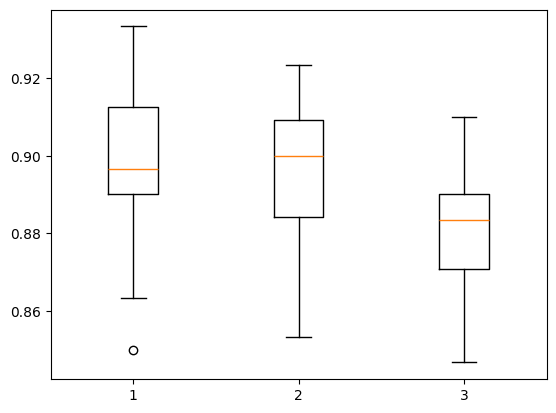

In [58]:
plt.boxplot([cover_rand, cover_wave, cover_fpca])
print(np.round(np.mean(cover_rand), 3), np.round(np.mean(cover_wave), 3), np.round(np.mean(cover_fpca), 3))
plt.show()